# **Locally Low Rank (LLR) Tutorial**

### Introduction:

  * LLR is an effective regularization technique
  * LLR enforces low rankness in the spatial-contrast dimension

### Authors:

  * Zhengguo Tan <zhengguo.tan@gmail.com>
  * Patrick A Liebig <patrick.liebig@siemens-healthineers.com>
  * Robin M Heidemann <robin.heidemann@siemens-healthineers.com>
  * Fredrik B Laun <Frederik.Laun@uk-erlangen.de>
  * Florian Knoll <florian.knoll@fau.de>

### References:

  * Cai JF, Candès EJ, Shen Z. [A singular value thresholding algorithm for matrix completion](https://doi.org/10.1137/080738970). SIAM J Optim 20:1956-1982 (2010).
  * Trzasko J, Manduca A. [Local versus global low-rank promotion in dynamic MRI series reconstruction](https://archive.ismrm.org/2011/4371.html). Proc Int Soc Magn Reson Med 19:4371 (2011).
  * Zhang T, Pauly J, Levesque I. [Accelerating parameter mapping with a locally low rank constraint](https://doi.org/10.1002/mrm.25161). 73:655-661 (2015).
  * Saucedo A, Lefkimmiatis S, Rangwala N, Sung K. [Improved computational efficiency of locally low rank MRI reconstruction using iterative random patch adjustments](https://doi.org/10.1109/TMI.2017.2659742). IEEE Trans Med Imaging 36:1209-1220 (2017).
  * Hu Y, Wang X, Tian Q, Yang G, Daniel B, McNab J, Hargreaves B. [Multi-shot diffusion-weighted MRI reconstruction with magnitude-based spatial-angular locally low-rank regularization (SPA-LLR)](https://doi.org/10.1002/mrm.28025). Magn Reson Med 83:1596-1607 (2020).

# 1. Setup

## Connect to a GPU on `Google Colab`

  * Go to `Edit` > `Notebook settings` > select `GPU` > click `Save`;
  * Now we can verify that we allocate a GPU for this notebook.

In [ ]:
!nvidia-smi
!nvcc --version

## Install SigPy

  * The original [SigPy](https://github.com/mikgroup/sigpy.git) was forked for the development of HD-MRI reconstruction and is available here: https://github.com/ZhengguoTan/sigpy.git

In [ ]:
!git clone https://github.com/ZhengguoTan/sigpy.git

In [ ]:
%cd /content/sigpy
!git log -1

In [ ]:
!pip install -e /content/sigpy

# 2. Load DWI

In [ ]:
%%bash

mkdir /content/data && cd "$_"
pwd

RECORD='8164048'

wget -q https://zenodo.org/record/${RECORD}/files/0.5x0.5x2.0mm_JETS_slice_000.h5

cd /content/sigpy

In [6]:
DATA_DIR = '/content/data/'

In [13]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

import sigpy as sp
from sigpy import linop, thresh, util

import time

In [46]:
f = h5py.File(DATA_DIR + '0.5x0.5x2.0mm_MUSE_slice_000.h5')
DWI = np.squeeze(f['dwi_comb_muse'][:])
f.close()

N_diff, N_z, N_y, N_x = DWI.shape
# N_diff : numbeer of diffusion encodings (diff)
# N_z    : number of slices
# N_y    : number of phase encodings
# N_x    : number of readouts

print(DWI.shape)

<KeysViewHDF5 ['dwi_comb_muse', 'nav_shot_muse', 'nav_shot_muse_phase']>
(4, 2, 440, 440)


In [9]:
A = sp.linop.ArrayToBlocks(DWI.shape, (1, 3, 3), (1, 1, 1))

y = A(DWI)

print(y.shape)
print(A.num_blks)

(4, 2, 438, 438, 1, 3, 3)
[2, 438, 438]


In [10]:
def Fwd(ishape, block_shape=(1, 3, 3), block_stride=(1, 1, 1)):
    """
    Args:
        ishape: shape of the input array
    """

    A = linop.ArrayToBlocks(ishape, block_shape, block_stride)
    
    block_len = len(block_shape)

    oshape = [util.prod(A.ishape[:-block_len]),  # number of diff
              util.prod(A.num_blks),             # number of blocks
              util.prod(block_shape)
             ]
    
    R1 = linop.Reshape(oshape, A.oshape)
    R2 = linop.Transpose(R1.oshape, axes=(1, 0, 2))
    
    return R2 * R1 * A

In [11]:
# define the forward operator:
Tl = Fwd(DWI.shape)

yl = Tl(DWI)

print("> The shape of matrices for SVT: ", yl.shape)
print("> SVD is applied onto the 2D matrices in the right most 2 dimensions")

> The shape of matrices for SVT:  (383688, 4, 9)
> SVD is applied onto the 2D matrices in the right most 2 dimensions


> block width and height is:  3
  The shape of matrices for SVT:  (383688, 4, 9)
  SVD takes  2.1838676929473877  seconds
> block width and height is:  6
  The shape of matrices for SVT:  (378450, 4, 36)
  SVD takes  3.4974849224090576  seconds
> block width and height is:  9
  The shape of matrices for SVT:  (373248, 4, 81)
  SVD takes  7.184869766235352  seconds
> block width and height is:  12
  The shape of matrices for SVT:  (368082, 4, 144)
  SVD takes  53.79961085319519  seconds


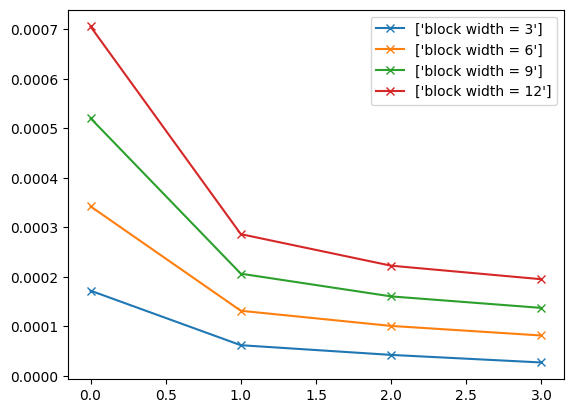

In [12]:
fig, ax = plt.subplots(1, 1)

for b in [3, 6, 9, 12]:

    start_time = time.time()

    print('> block width and height is: ', b)

    # define the forward operator for global low rank:
    T = Fwd(DWI.shape, block_shape=(1, b, b))

    # extract spatial-diffusion matrices
    y = T(DWI)

    print("  The shape of matrices for SVT: ", y.shape)
    
    u, s, vh = np.linalg.svd(y, full_matrices=False)
    
    end_time = time.time()
    
    print("  SVD takes ", end_time - start_time, ' seconds')
    
    ax.plot(np.mean(s, axis=0), '-x', label=['block width = ' + str(b)])

plt.legend()
plt.show()

In [29]:
def denoising(input, block_shape=(1, 3, 3), lamda=0.001):
    
    # define the forward operator for global low rank:
    T = Fwd(input.shape, block_shape=block_shape)

    # extract spatial-diffusion matrices
    y = T(input)

    u, s, vh = np.linalg.svd(y, full_matrices=False)

    # soft thresholding
    s_thresh = thresh.soft_thresh(lamda, s)
    
    output = (u * s_thresh[..., None, :]) @ vh
    
    # here we need the adjoint operator
    output = T.H(output)
    
    return output

In [44]:
DWI_b3 = denoising(DWI, block_shape=(1, 3, 3), lamda=0.00008)
DWI_b6 = denoising(DWI, block_shape=(1, 6, 6), lamda=0.00008)
DWI_b9 = denoising(DWI, block_shape=(1, 9, 9), lamda=0.00008)

DWI_disp = np.zeros_like(DWI, shape=[4, N_y, N_x])
DWI_disp[0] = DWI[1, 1, ...]
DWI_disp[1] = DWI_b3[1, 1, ...]
DWI_disp[2] = DWI_b6[1, 1, ...]
DWI_disp[3] = DWI_b9[1, 1, ...]

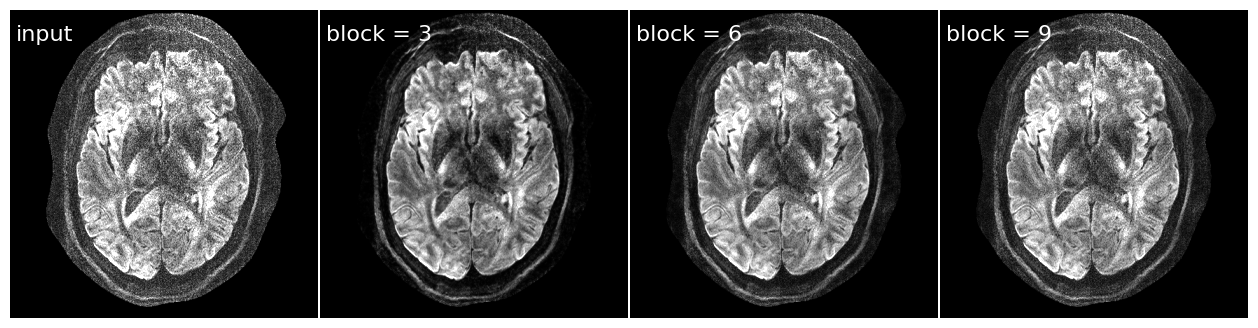

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

labels = ['input', 'block = 3', 'block = 6', 'block = 9']

for n in range(4):
    img = abs(np.flip(DWI_disp[n, :, :], axis=(0, 1)))
    ax[n].imshow(img, cmap='gray', vmin=0, vmax=0.0001)

    ax[n].text(int(0.02 * N_x), int(0.10 * N_y), labels[n], 
               color='w', fontsize=16)
    
    ax[n].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()